In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import gzip

In [ ]:
# download data
chrom_num = 20 # which chromosome's data to download
!wget -P data/ http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr1.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz

In [3]:
# open the VCF file
vcf_file = gzip.open('data/ALL.chr1.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz', 'rt')
print('File opened!')

File opened!


In [ ]:
variant_count = 100000 # number of variants to use

# extract the samples and variants
samples = []
variants = []

for count, line in enumerate(vcf_file):
    if count % 10000 == 0:
        print(f'Lines processed: {count}')
        
    if line.startswith('#CHROM'): # get sample ids
        samples = line.strip().split()[9:]
    
    elif not line.startswith('#'): # get genotypes at each variant
        variants.append(line.strip().split())

    if len(variants) == variant_count:
        break

vcf_file.close()
print('Done extracting!')

In [5]:
"""
Create matrix containing a numeric representation of genotypes for each individual at each variant site
Genotype of 0: Homozygous reference genotype, both alleles at the variant site are identical to the reference allele
Genotype of 1: Heterozygous genotype, only one allele at the variant site is identical to the reference allele
Genotype of 2: Homozygous alternate genotype, both alleles at the variant site are different from the reference allele
"""
genotypes = np.zeros((len(samples), len(variants)), dtype=np.float32)
for i, variant in enumerate(variants):
    for j in range(len(samples)):
        call = variant[9+j].split(':')[0]
        if call == './.' or call == './. ./.': # missing or invalid genotype at variant site
            print(f'Skipping sample {j} for variant {i} due to missing call: {call}')
            genotypes[j, i] = np.nan
        else:
            alleles = call.split('|')
            genotypes[j, i] = sum(map(int, alleles))

# filter out samples with missing/invalid genotypes at any variant site
genotypes = genotypes[~np.isnan(genotypes).any(axis=1), :]

print('Matrix created!')

Matrix created!


In [ ]:
# dimensions of genotypes matrix
print('Genotypes matrix shape:', genotypes.shape)

# inspect subset of matrix values
print('Subset of matrix values:')
print(genotypes[:20, :20])

In [24]:
# perform PCA on the genotypes matrix
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genotypes)

In [ ]:
sample_info = {} # key = sample_id, value = [population, super_population, gender]

# read file with demographic info for each sample
with open('data/integrated_call_samples_v3.20130502.ALL.panel', 'r') as file:
    
    next(file) # skip header

    for line in file: # extract info and add to dictionary
        columns = line.strip().split('\t')
        sample_info[columns[0]] = [columns[1], columns[2], columns[3]]

In [39]:
# create a dataframe for population counts
populations = [sample_info.get(sample_id, [None, None, None])[0] for sample_id in samples]
population_counts = pd.DataFrame({'Population': populations}).value_counts().reset_index()
population_counts.columns = ['Population', 'Count']
population_counts = population_counts.sort_values(by='Population')

# create a dataframe for superpopulation counts
superpopulations = [sample_info.get(sample_id, [None, None, None])[1] for sample_id in samples]
superpopulation_counts = pd.DataFrame({'Superpopulation': superpopulations}).value_counts().reset_index()
superpopulation_counts.columns = ['Superpopulation', 'Count']
superpopulation_counts = superpopulation_counts.sort_values(by='Superpopulation')

# create a dataframe for gender counts
genders = [sample_info.get(sample_id, [None, None, None])[2] for sample_id in samples]
gender_counts = pd.DataFrame({'Gender': genders}).value_counts().reset_index()
gender_counts.columns = ['Gender', 'Count']
gender_counts = gender_counts.sort_values(by='Gender')

# export counts to csv
population_counts.to_csv('data/csvs/population_counts.csv', index=False)
superpopulation_counts.to_csv('data/csvs/superpopulation_counts.csv', index=False)
gender_counts.to_csv('data/csvs/gender_counts.csv', index=False)

| Population                                | Superpopulation                         | Color    |
|-------------------------------------------|-----------------------------------------|----------|
| ACB (African Caribbean in Barbados)        | AFR (African)                           | #ff7f0e  |
| ASW (African Ancestry in Southwest USA)    | AFR (African)                           | #2ca02c  |
| BEB (Bengali in Bangladesh)                | SAS (South Asian)                       | #d62728  |
| CDX (Chinese Dai in Xishuangbanna, China)  | EAS (East Asian)                        | #9467bd  |
| CEU (Utah Residents with Northern and Western European Ancestry) | EUR (European)         | #8c564b  |
| CHB (Han Chinese in Beijing, China)        | EAS (East Asian)                         | #e377c2  |
| CHS (Southern Han Chinese)                 | EAS (East Asian)                         | #7f7f7f  |
| CLM (Colombian in Medellin, Colombia)      | AMR (Ad Mixed American)                  | #bcbd22  |
| ESN (Esan in Nigeria)                      | AFR (African)                            | #1f77b4  |
| FIN (Finnish in Finland)                   | EUR (European)                           | #9edae5  |
| GBR (British in England and Scotland)      | EUR (European)                           | #dbdb8d  |
| GIH (Gujarati Indian in Houston, USA)      | SAS (South Asian)                        | #c7c7c7  |
| GWD (Gambian in Western Divisions in the Gambia) | AFR (African)                         | #f7b6d2  |
| IBS (Iberian Population in Spain)          | EUR (European)                           | #c49c94  |
| ITU (Indian Telugu in the UK)              | SAS (South Asian)                        | #f1b0b0  |
| JPT (Japanese in Tokyo, Japan)             | EAS (East Asian)                         | #e7ba52  |
| KHV (Kinh in Ho Chi Minh City, Vietnam)    | EAS (East Asian)                         | #7b4173  |
| LWK (Luhya in Webuye, Kenya)               | AFR (African)                            | #a55194  |
| MSL (Mende in Sierra Leone)                | AFR (African)                            | #843c39  |
| MXL (Mexican Ancestry from Los Angeles, USA) | AMR (Ad Mixed American)                | #5254a3  |
| PEL (Peruvian in Lima, Peru)               | AMR (Ad Mixed American)                  | #6b6ecf  |
| PJL (Punjabi in Lahore, Pakistan)          | SAS (South Asian)                        | #9c9ede  |
| PUR (Puerto Rican in Puerto Rico)          | AMR (Ad Mixed American)                  | #637939  |
| STU (Sri Lankan Tamil in the UK)           | SAS (South Asian)                        | #b5cf6b  |
| TSI (Toscani in Italy)                     | EUR (European)                           | #17becf  |
| YRI (Yoruba in Ibadan, Nigeria)            | AFR (African)                            | #ff9896  |


In [41]:
# define colors for each superpopulation
superpopulation_colors = {
    'AFR': 'red',
    'AMR': 'blue',
    'EAS': 'green',
    'EUR': 'orange',
    'SAS': 'purple',
}

# define colors for each subpopulation
subpopulation_colors = {
    'ACB':'#ff7f0e',
    'ASW':'#2ca02c',
    'BEB':'#d62728',
    'CDX':'#9467bd',
    'CEU':'#8c564b',
    'CHB':'#e377c2',
    'CHS':'#7f7f7f',
    'CLM':'#bcbd22',
    'ESN':'#6b6ecf',
    'FIN':'#9edae5',
    'GBR':'#dbdb8d',
    'GIH':'#c7c7c7',
    'GWD':'#f7b6d2',
    'IBS':'#c49c94',
    'ITU':'#f1b0b0',
    'JPT':'#e7ba52',
    'KHV':'#7b4173',
    'LWK':'#a55194',
    'MSL':'#843c39',
    'MXL':'#5254a3',
    'PEL':'#17becf',
    'PJL':'#9c9ede',
    'PUR':'#637939',
    'STU':'#b5cf6b',
    'TSI':'#1f77b4',
    'YRI':'#d6616b',
}

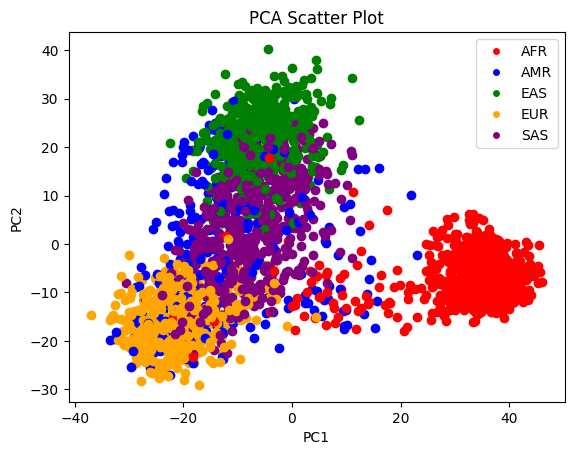

In [16]:
# extract PCA data points and superpopulations
data_points = pca_result[:, :2]  # Take the first two principal components

# create scatter plot
for data, superpop in zip(data_points, superpopulations):
    color = superpopulation_colors.get(superpop, 'gray')  # Use gray color for unknown superpopulations
    plt.scatter(data[0], data[1], color=color)

plt.title('PCA Results by Superpopulation')
plt.xlabel('PC1')
plt.ylabel('PC2')

# add superpopulation legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=superpop, markerfacecolor=color)
                   for superpop, color in superpopulation_colors.items()]
plt.legend(handles=legend_elements)

plt.savefig("results/pca_superpopulations")
plt.show()

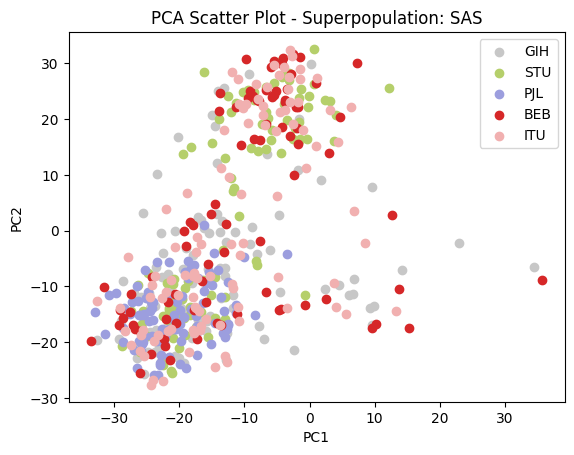

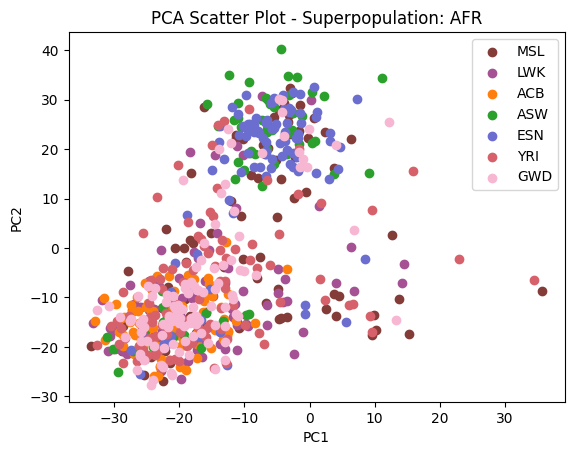

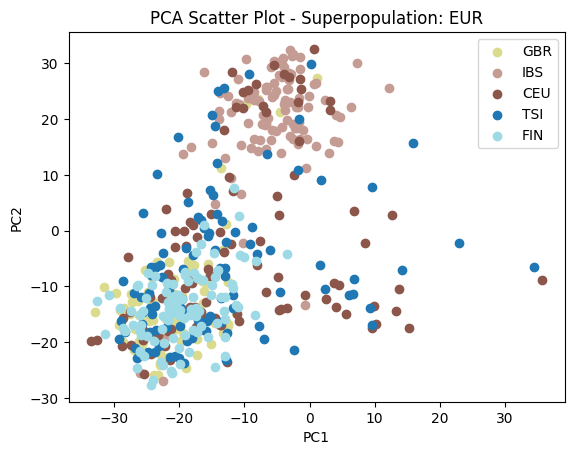

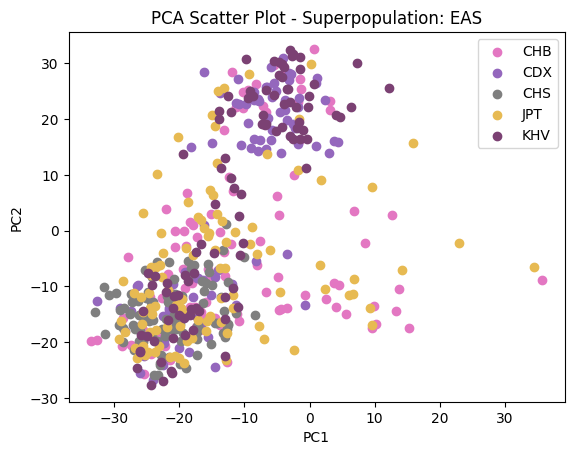

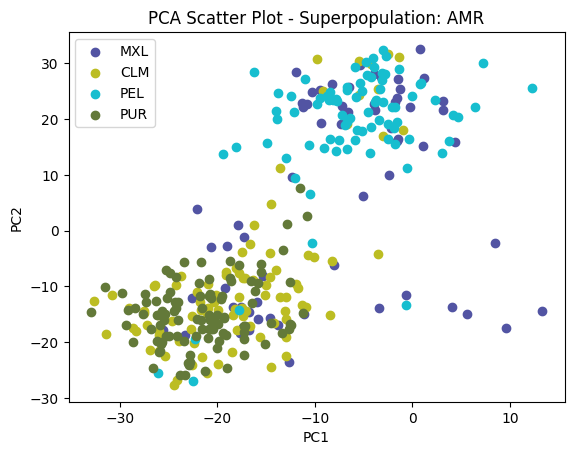

In [33]:
# perform PCA for each superpopulation
for superpop in superpopulations:
    # filter genotypes matrix and sample info for the current superpopulation
    superpop_genotypes = genotypes[[i for i, sample_id in enumerate(samples) if sample_info.get(sample_id, [None, None, None])[1] == superpop]]
    superpop_samples = [sample_id for sample_id in samples if sample_info.get(sample_id, [None, None, None])[1] == superpop]

    # perform PCA
    # pca = PCA(n_components=2)
    # pca_result = pca.fit_transform(superpop_genotypes)

    # extract PCA data points and subpopulations
    data_points = pca_result[:, :2]  # Take the first two principal components
    subpopulations = [sample_info.get(sample_id, [None, None, None])[0] for sample_id in superpop_samples]  # Extract subpopulations

    # create scatter plot for the current superpopulation
    plt.figure()
    for subpop in set(subpopulations):
        # filter data points for the current subpopulation
        subpop_data_points = [data for data, subpop_label in zip(data_points, subpopulations) if subpop_label == subpop]
        color = subpopulation_colors.get(subpop, 'gray')  # Use gray color for unknown subpopulations
        plt.scatter(*zip(*subpop_data_points), color=color, label=subpop)

    plt.title(f'PCA Scatter Plot - Superpopulation: {superpop}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    # add subpopulation legend
    plt.legend()

plt.show()

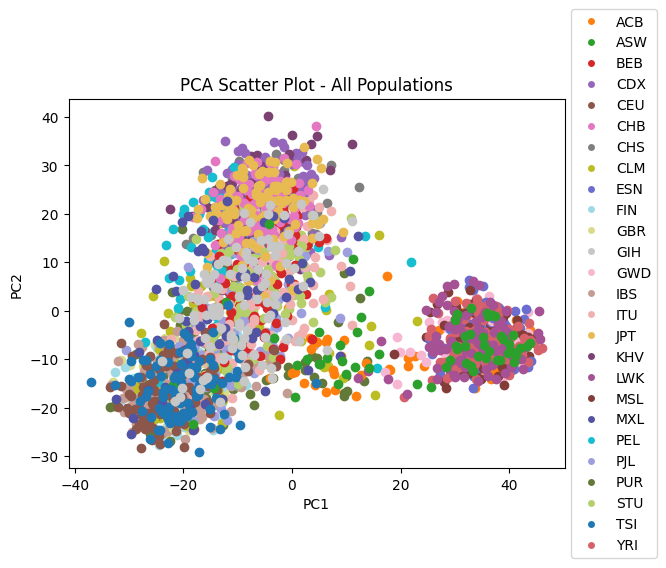

In [34]:
# get unique populations
unique_populations = list(set(populations))

# create a scatter plot
for data, pop in zip(pca_result[:, :2], populations):
    color = subpopulation_colors.get(pop, 'gray')  # Use gray color for unknown populations
    plt.scatter(data[0], data[1], color=color)

plt.title('PCA Scatter Plot - All Populations')
plt.xlabel('PC1')
plt.ylabel('PC2')

# create population legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=pop, markerfacecolor=color)
                   for pop, color in subpopulation_colors.items() if pop in unique_populations]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()